In [1]:
import numpy as np
import scipy.stats
import pylab as plt

from astropy.stats import median_absolute_deviation
from astroML import stats as astroMLstats

from tqdm import tqdm

# Monte Carlo integration

You might have seen this already, but Monte Carlo integration is an absolute crucial notion in modern statistics (modern because it relies on generating a large number of data points, which has been made possible by computers). Suppose you have very a complicated integral to solve and that you can write down the integrand as a product of $f(x)$ and $p(x)$ with $\int p(x)=1$ (this is not restrictive at all! See below). My nasty integral is

$$\int f(x) p(x) dx$$


Provided one can **evaluate** $f(x)$ and **sample** $p(x)$, then


$$\int f(x) p(x) dx \approx \frac{1}{N}\sum_{i=1}^N f(x_i) $$

where $x_i$ are samples drawn from $p$. 

## A gaussian integral

Using Monte Carlo integration, check that

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

- Does the result converge with the number of samples? And how does the error go down?
- Do it many times. For a given $N$, how are the result distributed? We'll talk about model fitting at lenght later on, but for now try to fit it by hand with a parametrized model. (If N is large enough you should get something that looks *very* accurate! And if $N$ is small?)
- How does the distribution change if $N$ increases?

(Hint: think about sample mean and sample variance)


## Solution

The Gaussian distribution is given by:

$$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)$$

Therefore we can write the above integral as:

$$ \sigma\sqrt{2\pi}\int_0^\infty x^3 \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx $$

Where we can identify $f(x)=x^3$ and a Gaussian distribution with $\mu=0$ and standard deviation $\sigma$.

We can now compute the integral as:

$$ I = \sigma\sqrt{\frac{\pi}{2}} \frac{1}{N}\sum_{i=1}^N{x_i^3} $$

where $x_i$ are positive values (integral from $0$ to $\infty$, so we divide by two) generated from a the Gaussian distribution having $\mu=0$ and $\sigma=\sigma$. 

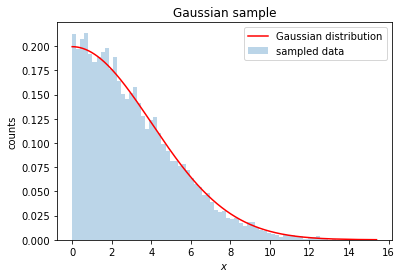

In [9]:
# Gaussian parameters
mu = 0
sigma = 4

# number of samples
N = 10000

gauss_distr = scipy.stats.norm(mu,sigma)
x = abs(gauss_distr.rvs(N))

# plot the Gauss distr
plt.hist(x,bins=75,density=True,alpha=0.3,label='sampled data')
plt.plot(np.sort(x),2*gauss_distr.pdf(x)[np.argsort(x)],label='Gaussian distribution',color='red')
plt.xlabel('$x$')
plt.ylabel('counts')
plt.title('Gaussian sample')
plt.legend()
plt.show()

In [10]:
# compute the integral:
num_integral = np.sum(x**3)*sigma*np.sqrt(np.pi/2)/N
known_result = 2*sigma**4
print('Numerical integral (N=%i): %.3f'%(N,num_integral))
print('Analytical solution:',known_result)

Numerical integral (N=10000): 485.696
Analytical solution: 512


In [11]:
# define a function to compute the integral:

def MC_integral(sigma,N):
    '''Computes the integral with MC: N is the number of samples to draw'''
    # define the gaussian
    gauss_distr = scipy.stats.norm(0,sigma)
    # extract N samples
    x = abs(gauss_distr.rvs(N))
    
    return np.sum(x**3)*sigma*np.sqrt(np.pi/2)/N
    
def known_integral(sigma):
    '''Computes the expected result'''
    return 2*sigma**4

Let's study the convergency with the number of samples:

In [12]:
num_integral_array = np.zeros(N)

for n in tqdm(range(1,N)):
    num_integral_array[n] = MC_integral(sigma,n)

100%|██████████| 9999/9999 [00:14<00:00, 708.78it/s]


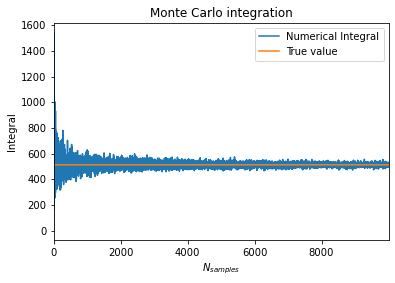

In [14]:
plt.plot(np.arange(1,N),num_integral_array[:-1],label='Numerical Integral')
plt.plot(np.arange(1,N),[known_integral(sigma)]*(N-1),label='True value')
plt.xlim(0,len(num_integral_array[num_integral_array!=0]))
plt.title('Monte Carlo integration')
plt.xlabel('$N_{samples}$')
plt.ylabel('Integral')
plt.legend()

Compute the errors and see how it changes with the number of samples

[]

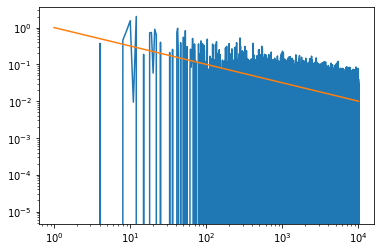

In [23]:
plt.plot(np.arange(1,N),(num_integral_array[:-1]-known_integral(sigma))/(known_integral(sigma)))
plt.plot(np.arange(1,N),np.arange(1,N)**(-1/2))
plt.loglog()

Iterating over the number of samples:

In [6]:
N_sampl = np.array([10,100,1000,10000]) # number of samples to generate
N_iter = 1000 # number of iteration for each N_sampl

num_integral_Nsampl = np.empty([len(N_sampl),N_iter])

for n in tqdm(range(len(N_sampl))):
    for i in range(N_iter):
        x = abs(gauss_distr.rvs(N_sampl[n]))
        num_integral_Nsampl[n,i] = np.sum(x**3)*sigma*np.sqrt(np.pi/2)/N_sampl[n]

100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


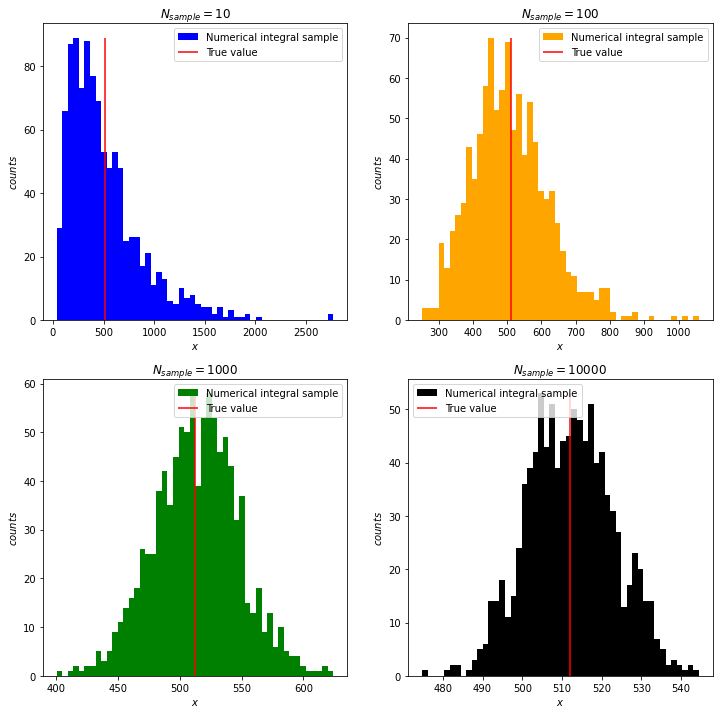

In [69]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12))
color = ['blue','orange','green','black']

for i in range(len(N_sampl)):
    ax = ax.ravel()
    ax[i].vlines(known_result,0,max(ax[i].hist(num_integral_Nsampl[i],bins=50)[0]),color='red',label='True value')
    ax[i].hist(num_integral_Nsampl[i],bins=50,color=color[i],label='Numerical integral sample')
    ax[i].set_xlabel(r'$x$')
    ax[i].set_ylabel(r'$counts$')
    ax[i].set_title(r'$N_{sample}=%i$'%N_sampl[i])
    ax[i].legend()
    

Try to fit 'manually' the $N=10000$ result's distribution with a gaussian



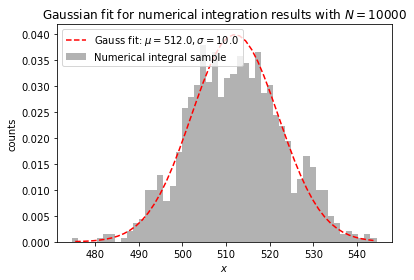

In [81]:
# xdata from the histogram object
counts,bins = np.histogram(num_integral_Nsampl[-1],bins=50) 
bin_center = (bins[:-1]+bins[1:])/2

# Gaussian fit parameters
mu_fit = known_result
sigma_fit = 10

# gaussian object
gauss_fit = scipy.stats.norm(mu_fit,sigma_fit)

# plot
plt.plot(bin_center, gauss_fit.pdf(bin_center),color='red',label='Gauss fit: $\mu=%.1f, \sigma=%.1f$'%(mu_fit,sigma_fit),linestyle='--')
plt.hist(num_integral_Nsampl[-1],bins=50,color='black',label='Numerical integral sample',alpha=0.3,density=True)
plt.xlabel(r'$x$')
plt.ylabel(r'counts')
plt.title('Gaussian fit for numerical integration results with $N=10000$')
plt.legend()
plt.show()